# Big Data Project for Computing Infrastructures course by Francesco Picciotti (matr.854021) 
--------

## Task: Ammoniacal Nitrogen as N (Ammonia) quantity forecast in Hertfordshire and North London water

## Imports

In [1]:
import numpy as np
import pandas as pd
import ibmos2spark
from pyspark.sql import SparkSession
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.metrics import mean_squared_error

/gpfs/fs01/user/sab4-ac4c04bfbf16cb-c66109041f31/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Import dataset from Object Store

In [2]:
# The code was removed by DSX for sharing.

# Original dataset
---

The dataset contains the samples of determinands, which most of the cases are pollutant, from different materials taken in many stretch of water in the Hertfordshire and North London area from 2009 and 2016

In [3]:
df_data_1.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- @id: string (nullable = true)
 |-- sample.samplingPoint: string (nullable = true)
 |-- sample.samplingPoint.notation: string (nullable = true)
 |-- sample.samplingPoint.label: string (nullable = true)
 |-- sample.sampleDateTime: string (nullable = true)
 |-- determinand.label: string (nullable = true)
 |-- determinand.definition: string (nullable = true)
 |-- determinand.notation: string (nullable = true)
 |-- resultQualifier.notation: string (nullable = true)
 |-- result: string (nullable = true)
 |-- codedResultInterpretation.interpretation: string (nullable = true)
 |-- determinand.unit.label: string (nullable = true)
 |-- sample.sampledMaterialType.label: string (nullable = true)
 |-- sample.isComplianceSample: string (nullable = true)
 |-- sample.purpose.label: string (nullable = true)
 |-- sample.samplingPoint.easting: string (nullable = true)
 |-- sample.samplingPoint.northing: string (nullable = true)



In [4]:
df_data_1.head(2)

[Row(_c0=u'0', @id=u'http://environment.data.gov.uk/water-quality/data/measurement/TH-1111137-0092', sample.samplingPoint=u'http://environment.data.gov.uk/water-quality/id/sampling-point/TH-PBRE9999', sample.samplingPoint.notation=u'TH-PBRE9999', sample.samplingPoint.label=u'BRENT CATCHMENT EFFLUENT N.C.R.S', sample.sampleDateTime=u'2013-04-22T17:30:00', determinand.label=u'COD as O2', determinand.definition=u'Chemical Oxygen Demand :- {COD}', determinand.notation=u'92', resultQualifier.notation=None, result=u'138.0', codedResultInterpretation.interpretation=None, determinand.unit.label=u'mg/l', sample.sampledMaterialType.label=u'RIVER / RUNNING SURFACE WATER', sample.isComplianceSample=u'False', sample.purpose.label=u'UNPLANNED REACTIVE MONITORING FORMAL (POLLUTION INCIDENTS)', sample.samplingPoint.easting=u'500000', sample.samplingPoint.northing=u'7'),
 Row(_c0=u'1', @id=u'http://environment.data.gov.uk/water-quality/data/measurement/TH-1111137-0085', sample.samplingPoint=u'http://en

In [5]:
dataRDD = df_data_1.rdd

In [6]:
dataRDD.cache()

MapPartitionsRDD[13] at javaToPython at NativeMethodAccessorImpl.java:0

# Taking all the Ammonia sampling
The most frequent pollutant in the dataset is the Ammoniacal Nitrogen as N (Ammonia), which is from food processing waste and harms all the organisms. So the goal is to create a model to forecast the daily quantity of Ammonia. 

In [7]:
df = dataRDD.filter(lambda x: x['determinand.label']=="Ammonia(N)").map(
    lambda x: (x['sample.sampleDateTime'], float(x['result']))).sortByKey().toDF(["Date", "Values"]).toPandas()

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
indexed_df = df.set_index('Date')
indexed_df.head()

,Values
Date,
2009-01-05 10:17:00,1.530
2009-01-05 10:37:00,0.068
2009-01-05 11:05:00,0.030
2009-01-05 11:22:00,0.030
2009-01-05 11:41:00,0.030


This is the initial time series' head, let's start to clean and process it!

In [9]:
#Drop duplicates and see the distribution
indexed_df = indexed_df[~indexed_df.index.duplicated(keep='first')]
print(sum(indexed_df.isnull().values.ravel()))
indexed_df.describe()

0


,Values
count,16744.000000
mean,1.365752
std,14.404452
min,0.020000
25%,0.033000
50%,0.129000
75%,0.360000
max,873.000000


In [10]:
ts = indexed_df['Values']
ts.head()

Date
2009-01-05 10:17:00    1.530
2009-01-05 10:37:00    0.068
2009-01-05 11:05:00    0.030
2009-01-05 11:22:00    0.030
2009-01-05 11:41:00    0.030
Name: Values, dtype: float64

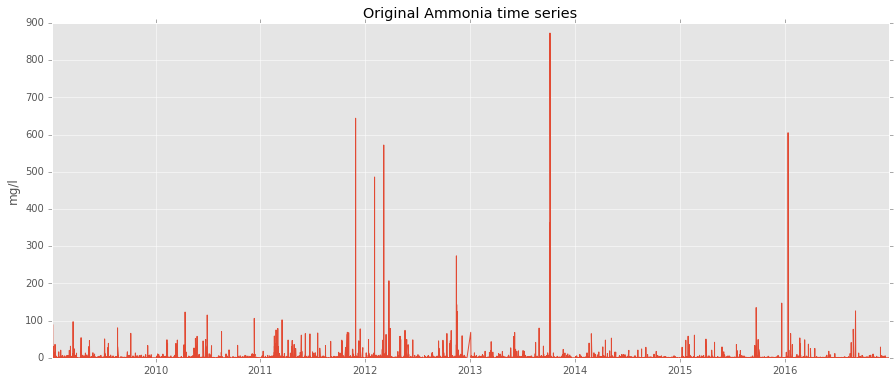

In [11]:
#Plot of the original time series
plt.axes(ylabel = 'mg/l')
plt.title('Original Ammonia time series')
plt.plot(ts)

## Helper functions 

In [12]:
def test_stationarity(timeseries):
    """
    This method plots the rolling mean and standard deviation of 7 steps of the 
    given ts and performs the Dickey-Fuller test. It's a statistical test with 
    the null hypothesis that the time series is non-stationary. 
    If the test results in the test statistic significantly less than the critical values, 
    we can reject the null hypothesis in favor of time series stationarity.

    Args:
        timeseries: the ts to plot the rolling avg and std and check stationarity.
    Returns:
        nothing
    Raises:
        nothing
    """
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7, center=False).mean() 
    rolstd = timeseries.rolling(window=7, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [13]:
def remove_outliers(ts):
    """
    The following method detects and removes all the outliers,
    thus all the samples that fall outside the box plot of the
    distribution.
    
    Args:
        ts: the ts from which remove outliers.
    Returns:
        the ts without outliers that are replaced by third and first quartiles.
    Raises:
        nothing
    """
    
    first_quartile, third_quartile = ts.quantile([0.25, 0.75])


    iqr = third_quartile - first_quartile
    upper_bound = (third_quartile + 1.5*iqr) - 0.1
    lower_bound = (first_quartile - 1.5*iqr) + 0.1
    upper_val = ( third_quartile + upper_bound ) / 2
    lower_val = ( first_quartile + lower_bound ) / 2

    ts = ts.mask(
        lambda x: x > upper_bound, other = upper_bound).mask(
        lambda x: x < lower_bound, other = lower_bound)
    return ts

In [14]:
def decompose(timeseries):
    """
    It decomposes the ts into three parts trend, seasonal and residual.
    
    Args:
        timeseries: the ts to decompose.
    Returns:
        A tuple with trend, seasonal and residual within the ts
    Raises:
        nothing
    """
    
    decomposition = seasonal_decompose(timeseries.values, freq=int(24), model='additive')

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    timeseries_log = np.log(timeseries)
    plt.subplot(411)
    plt.plot(timeseries_log[-80:], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend[-80:], label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal[-80:],label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual[-80:], label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return (trend, seasonal, residual)

In [15]:
def boxcox_test(timeseries):
    """
    The following method does the Box-Cox test to find the most suitable
    transformation to smooth the ts.
    The ts is transformed with the following formula using the lambda with
    to which corresponds the highest probablily correlation coefficient in
    the normality plot:
        T(Y) = (Y^lambda -1)^lambda
    
    Args:
        timeseries: the ts find the most suitable transformation.
    Returns:
        nothing
    Raises:
        nothing
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    prob = stats.boxcox_normplot(timeseries, -20, 20, plot=ax)
    _, maxlog = stats.boxcox(timeseries)
    ax.axvline(maxlog, color='r')

## Time series preprocessing and cleaning

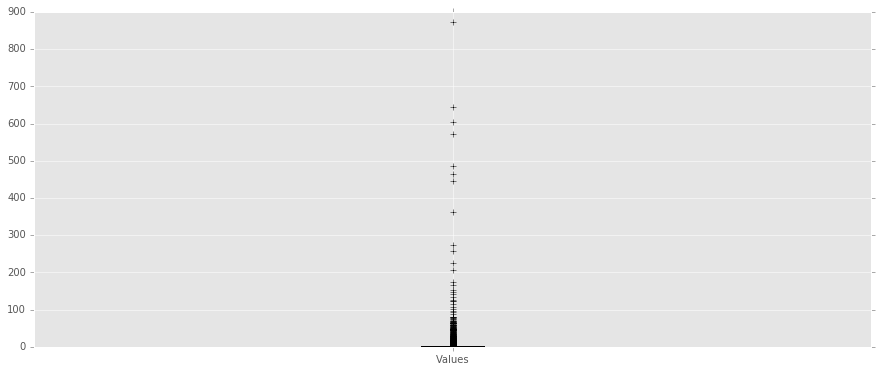

In [16]:
ts.plot.box()

In [17]:
ts_out = remove_outliers(ts.copy())

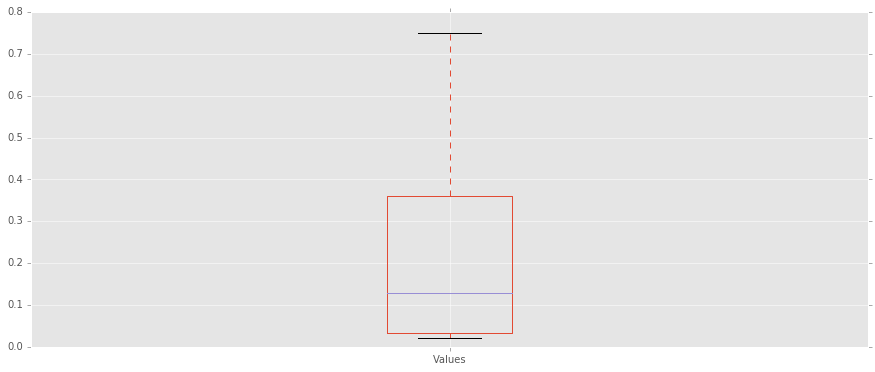

In [18]:
# Box plot of the distribution 
ts_out.plot.box()

Resampling the observations in order to obtain daily measurements and impute missing values with the previous value

In [19]:
ts_day = ts_out.resample('D').mean()
ts_day.fillna(method='backfill', inplace=True)

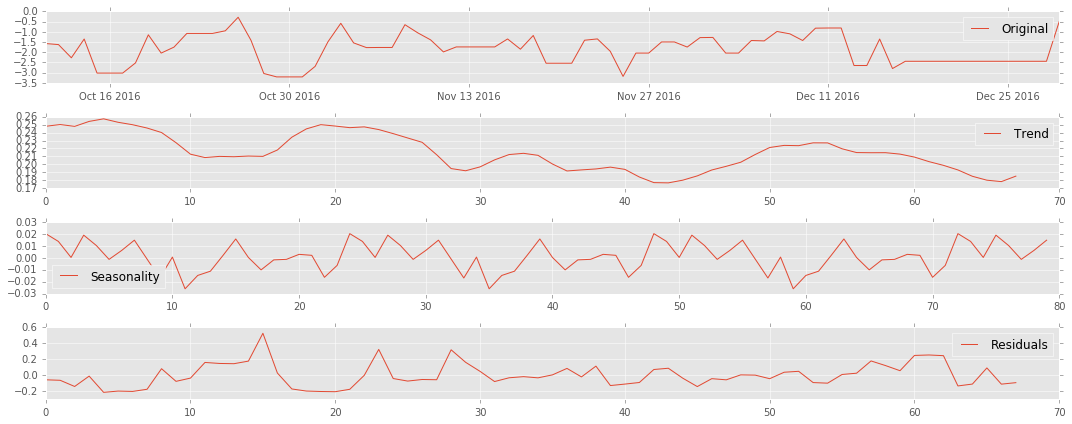

In [20]:
trend, season, residual = decompose(ts_day)
ts_deseas = ts_day - season

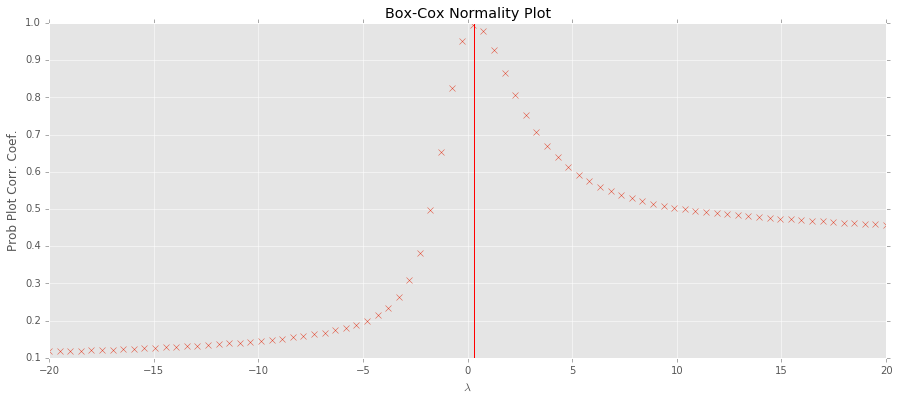

In [21]:
boxcox_test(ts_deseas)

According the Box-Cox Test, the lambda with the highest correlation coefficient is 0 so the transformation to apply is the logarithm

In [22]:
ts_tr = np.log(ts_deseas.copy())

Let's now scale the timeseries in values between 0 and 1

In [23]:
ts_sc = (ts_tr - ts_tr.min()) / (ts_tr.max() - ts_tr.min())

Let's check whether the ts is stationary with the augmented Dickey-Fuller test

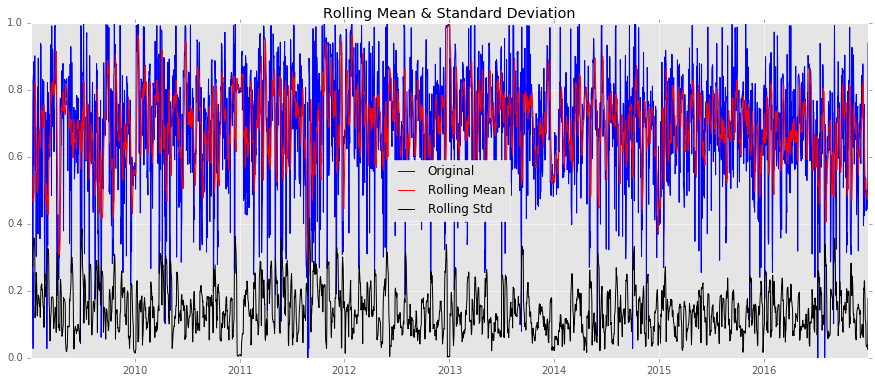

Results of Dickey-Fuller Test:
Test Statistic                  -25.141740
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    2913.000000
Critical Value (5%)              -2.862533
Critical Value (1%)              -3.432597
Critical Value (10%)             -2.567298
dtype: float64


In [24]:
test_stationarity(ts_sc)

Since the test statistic is definitely lower than the 1% critical value and the p-value is almost 0 

## Modeling with ARMA models

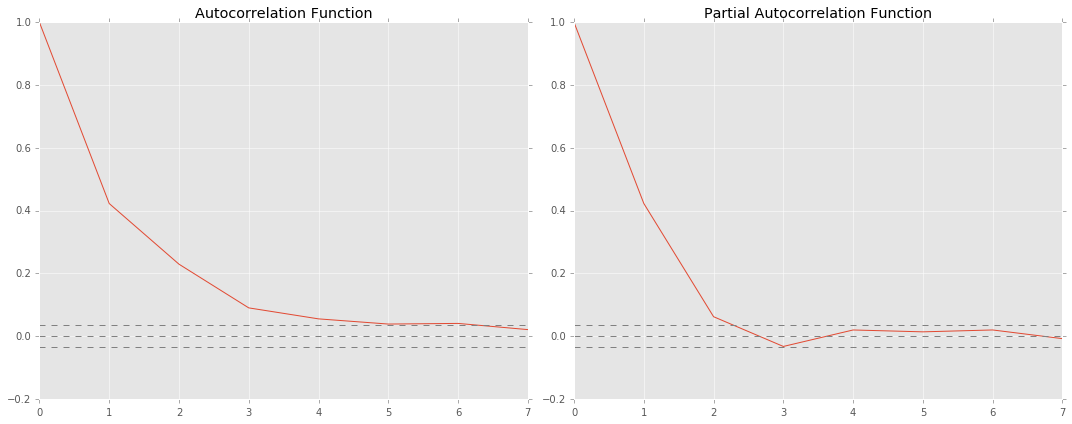

In [25]:
#ACF and PACF plots
ts_cleaned = ts_sc.copy()

lag_acf = acf(ts_cleaned, nlags=7)
lag_pacf = pacf(ts_cleaned, nlags=7)

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_cleaned)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_cleaned)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_cleaned)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_cleaned)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [26]:
import warnings
warnings.filterwarnings("ignore")
arma_order_select_ic(ts_cleaned, max_ar=10, max_ma=10, ic=['bic', 'aic'])

{'aic':              0            1            2            3            4   \
 0  -1667.033115 -2108.154805 -2233.900997 -2244.767006 -2246.235464   
 1  -2238.825694 -2246.251848 -2248.736528 -2248.372644 -2246.514172   
 2  -2247.772516 -2249.670670 -2247.746078 -2246.509771 -2244.517278   
 3  -2249.018244 -2247.741514 -2245.748674 -2244.789751 -2242.645614   
 4  -2248.098476 -2246.816231 -2246.722393 -2244.770650 -2242.960229   
 5  -2246.619715 -2244.972174 -2253.307933 -2251.654189 -2241.069386   
 6  -2245.745972 -2243.820179 -2244.372920 -2241.778655 -2240.370887   
 7  -2243.940100 -2242.670305 -2245.132848 -2239.263339 -2244.428189   
 8  -2242.779300 -2240.817346 -2238.734348 -2237.802179 -2236.012640   
 9  -2240.869012 -2238.968681 -2236.904920 -2239.048990 -2234.586931   
 10 -2239.279122 -2237.279172 -2234.958112 -2234.403737 -2235.355887   
 
              5            6            7            8            9   \
 0  -2244.408347 -2244.634619 -2244.585450 -2242.818343

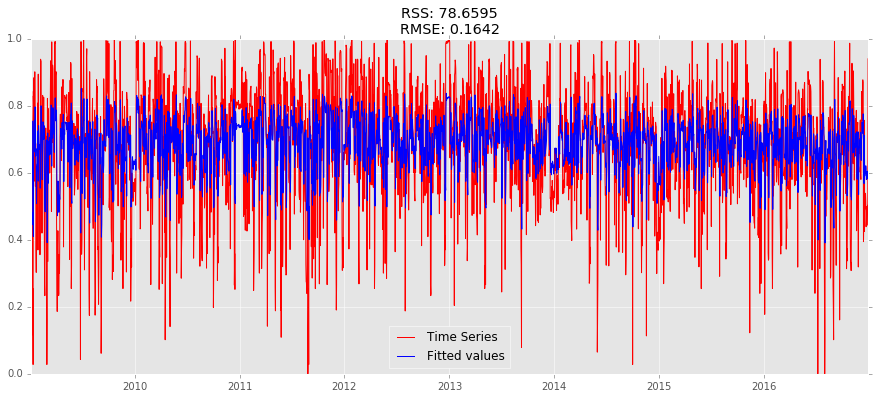

In [27]:
model = ARMA(ts_cleaned, order=(2, 1))
results_ARMA = model.fit(disp=-1)
plt.plot(ts_cleaned, color='red', label='Time Series')
plt.plot(results_ARMA.fittedvalues, color='blue', label='Fitted values')
plt.legend(loc='best')
plt.title('RSS: %.4f\nRMSE: %.4f' %(
    sum((results_ARMA.fittedvalues-ts_cleaned)**2),np.sqrt(mean_squared_error(ts_cleaned,results_ARMA.fittedvalues))))

## Now let's bring the ARMA's preditions to back to the original data shape

In [28]:
predictions_ARMA = pd.Series(results_ARMA.fittedvalues, copy=True)
print predictions_ARMA.head()

Date
2009-01-05    0.688745
2009-01-06    0.641486
2009-01-07    0.717299
2009-01-08    0.755011
2009-01-09    0.721854
Freq: D, dtype: float64


### Inverse transformation to data: 

In [29]:
predictions_ARMA_denorm = predictions_ARMA * (ts_tr.max() - ts_tr.min()) + ts_tr.min()
predictions_ARMA_exp = np.exp(predictions_ARMA_denorm)
predictions_ARMA_seas = predictions_ARMA_exp + season

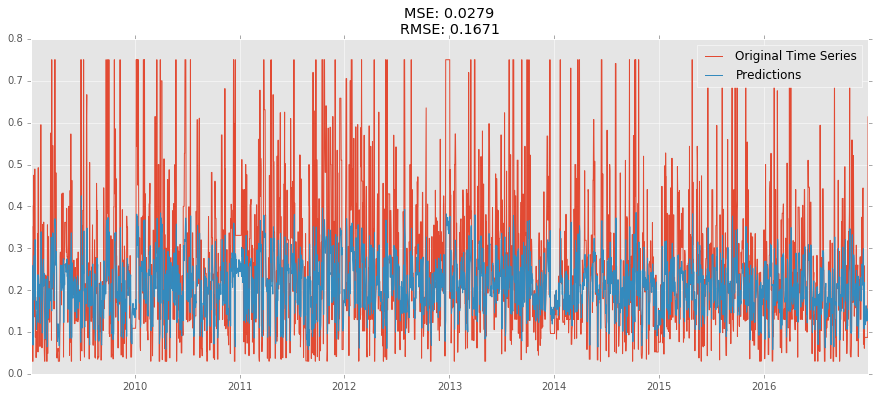

In [30]:
plt.plot(ts_day, label='Original Time Series')
plt.plot(predictions_ARMA_seas, label='Predictions')
plt.legend(loc='best')
plt.title('MSE: %.4f\nRMSE: %.4f' %(
    mean_squared_error(ts_day,predictions_ARMA_seas), np.sqrt(mean_squared_error(ts_day,predictions_ARMA_seas))))

## Model Validation

### First way: Whiteness test (or Anderson Test) of the error

                              ARMA Model Results                              
Dep. Variable:                 Values   No. Observations:                 2916
Model:                     ARMA(2, 1)   Log Likelihood                1129.835
Method:                       css-mle   S.D. of innovations              0.164
Date:                Tue, 29 Aug 2017   AIC                          -2249.671
Time:                        07:43:18   BIC                          -2219.781
Sample:                    01-05-2009   HQIC                         -2238.904
                         - 12-29-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6887      0.006    125.067      0.000       0.678       0.700
ar.L1.Values    -0.0873      0.187     -0.466      0.641      -0.454       0.280
ar.L2.Values     0.2668      0.075      3.56

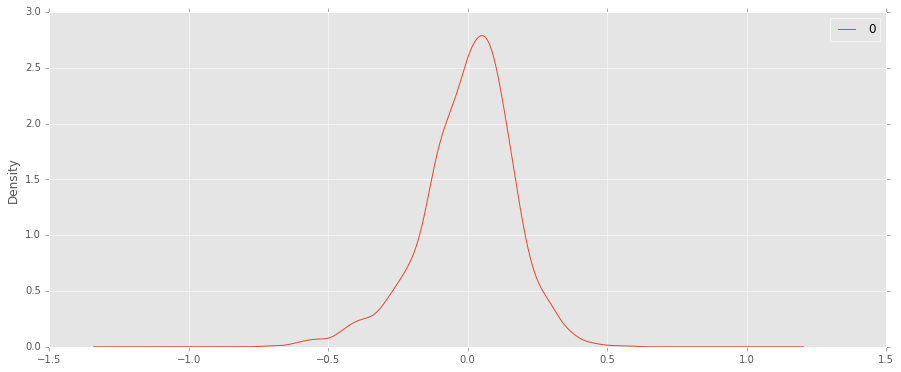

In [31]:
print(results_ARMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

By evaluating the residual's distribution, which is the error thus the stochastic part, we need to ensure it's is a white noise.
From the plot we can see that the error is very close to a Gaussian distribution with null mean and variance enough close to 1. This confirms the model's goodness.

### Second way: Out-sample performances evaluation 
Let's evaluate the model performances on the last 50 days

In [32]:
size = int(len(ts_cleaned) - 50)
train, test = ts_cleaned[0:size], ts_cleaned[size:len(ts_cleaned)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARMA(history, order=(2,1))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.4f' % error)
print('Test RMSE: %.4f' % np.sqrt(error))

predictions_series = pd.Series(predictions, index = test.index)
test_series = pd.Series(test, index = test.index)

Printing Predicted vs Expected Values...


predicted=2.134943, expected=2.082408
predicted=2.030191, expected=1.783485
predicted=1.912293, expected=1.938360
predicted=1.952645, expected=1.976829
predicted=1.991868, expected=1.934183
predicted=1.965817, expected=1.997709
predicted=1.992444, expected=2.142999
predicted=2.053094, expected=1.917252
predicted=1.972299, expected=2.196300
predicted=2.060767, expected=1.533171
predicted=1.813497, expected=1.612015
predicted=1.788490, expected=1.658210
predicted=1.845474, expected=2.089758
predicted=2.007235, expected=2.119363
predicted=2.061210, expected=1.835457
predicted=1.928647, expected=1.375904
predicted=1.709514, expected=1.856555
predicted=1.891435, expected=1.826796
predicted=1.938233, expected=2.002388
predicted=1.976914, expected=2.016865
predicted=2.012754, expected=1.932247
predicted=1.964849, expected=2.113647
predicted=2.037009, expected=2.134351
predicted=2.057973, expected=1.811067
predicted=1.923117, expected=1.786866
predict

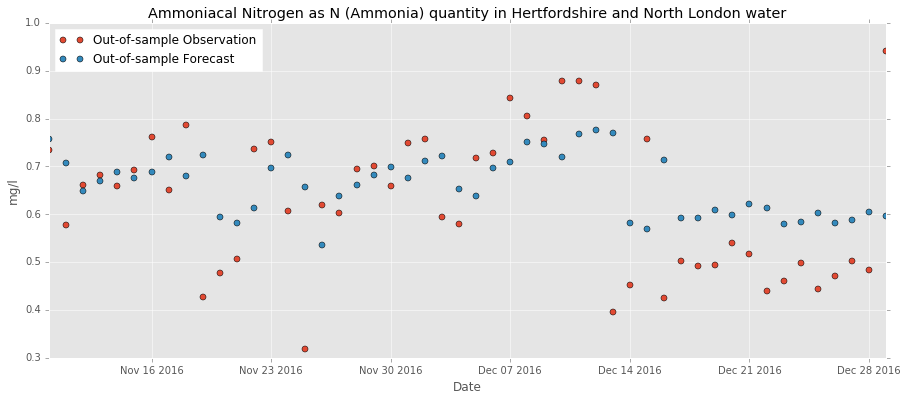

In [33]:
fig, ax = plt.subplots()
ax.set(title='Ammoniacal Nitrogen as N (Ammonia) quantity in Hertfordshire and North London water', xlabel='Date', ylabel='mg/l')
ax.plot(test_series, 'o', label='Out-of-sample Observation')
ax.plot(predictions_series, 'o', label='Out-of-sample Forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

## References

- Spark and Pyspark doc
- Spark understanding and basic knowledge from Big Data part held by prof. Ardagna during the Computing Infrustructures course
- Statsmodels python module references http://www.statsmodels.org/stable/index.html
- Notes from Model Identification and Data Analysis (MIDA/IMAD) course @ Polimi by prof. Bittanti and Savaresi
- Statistical forecasting: notes on regression and time series analysis by Robert Nau (Fuqua School of Business, Duke University) http://people.duke.edu/~rnau/411home.htm
- Cross Validated: Stack Overflow for stats guys https://stats.stackexchange.com/